<a href="https://colab.research.google.com/github/wonjae124/Capston/blob/colab/widedeep_auc_multiclass_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AUC multiclass computation

In [2]:
import os, sys
from google.colab import drive
drive.mount('/content/drive')

# my_path = '/content/notebooks'
# os.symlink('/content/drive/My Drive/Colab Notebooks/my_env', my_path) ## 소프트 link 파일 혹은 폴더를 만들 때 사용
# sys.path.insert(0, my_path)
#https://teddylee777.github.io/colab/colab%EC%97%90%EC%84%9C-python%ED%8C%A8%ED%82%A4%EC%A7%80%EB%A5%BC-permanently-%EC%9D%B8%EC%8A%A4%ED%86%A8%ED%95%98%EB%8A%94-%EB%B0%A9%EB%B2%95

!pip install --target=$my_path pytorch-widedeep
!pip install --target=$my_path git+https://github.com/jrzaurin/pytorch-widedeep.git

Mounted at /content/drive
     |████████████████████████████████| 21.1 MB 1.4 MB/s 
     |████████████████████████████████| 398 kB 47.9 MB/s 
     |████████████████████████████████| 52.7 MB 71.0 MB/s 
     |████████████████████████████████| 1.5 MB 35.0 MB/s 
     |████████████████████████████████| 1.6 MB 63.2 MB/s 
     |████████████████████████████████| 136 kB 53.0 MB/s 
     |████████████████████████████████| 4.1 MB 38.3 MB/s 
     |████████████████████████████████| 226 kB 62.9 MB/s 
     |████████████████████████████████| 125 kB 59.9 MB/s 
  Attempting uninstall: grpcio
    Found existing installation: grpcio 1.44.0
    Uninstalling grpcio-1.44.0:
      Successfully uninstalled grpcio-1.44.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.0 requires tf-estimator-nightly==2.8.0.dev2021122109, which is not installed.
  Cloning https://github.com

## Initial imports

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns

from torch.optim import SGD, lr_scheduler

from pytorch_widedeep import Trainer
from pytorch_widedeep.preprocessing import TabPreprocessor
from pytorch_widedeep.models import TabMlp, WideDeep
from torchmetrics import AUC, AUROC, Precision, Recall, F1Score
from pytorch_widedeep.initializers import XavierNormal
from pytorch_widedeep.datasets import load_ecoli
from pytorch_widedeep.utils import LabelEncoder
from sklearn.model_selection import train_test_split

# increase displayed columns in jupyter notebook
pd.set_option("display.max_columns", 200)
pd.set_option("display.max_rows", 300)

In [4]:
df = load_ecoli(as_frame=True)
df

,SequenceName,mcg,gvh,lip,chg,aac,alm1,alm2,class
0,AAT_ECOLI,0.49,0.29,0.48,0.5,0.56,0.24,0.35,cp
1,ACEA_ECOLI,0.07,0.40,0.48,0.5,0.54,0.35,0.44,cp
2,ACEK_ECOLI,0.56,0.40,0.48,0.5,0.49,0.37,0.46,cp
3,ACKA_ECOLI,0.59,0.49,0.48,0.5,0.52,0.45,0.36,cp
4,ADI_ECOLI,0.23,0.32,0.48,0.5,0.55,0.25,0.35,cp
...,...,...,...,...,...,...,...,...,...
331,TREA_ECOLI,0.74,0.56,0.48,0.5,0.47,0.68,0.30,pp
332,UGPB_ECOLI,0.71,0.57,0.48,0.5,0.48,0.35,0.32,pp
333,USHA_ECOLI,0.61,0.60,0.48,0.5,0.44,0.39,0.38,pp
334,XYLF_ECOLI,0.59,0.61,0.48,0.5,0.42,0.42,0.37,pp


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 336 entries, 0 to 335
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   SequenceName  336 non-null    object 
 1   mcg           336 non-null    float64
 2   gvh           336 non-null    float64
 3   lip           336 non-null    float64
 4   chg           336 non-null    float64
 5   aac           336 non-null    float64
 6   alm1          336 non-null    float64
 7   alm2          336 non-null    float64
 8   class         336 non-null    object 
dtypes: float64(7), object(2)
memory usage: 23.8+ KB


In [6]:
# imbalance of the classes
df["class"].value_counts()

cp     143
im      77
pp      52
imU     35
om      20
omL      5
imS      2
imL      2
Name: class, dtype: int64

In [7]:
df = df.loc[~df["class"].isin(["omL", "imS", "imL"])] # 차지하는 수가 적은 클래스는 버림 336개에서 327개로 줄어듬
df.reset_index(inplace=True, drop=True) # 이거 필요한가? 아마 맨 앞에 있는 콜럼이 순서인듯 하다.

In [8]:
df

,SequenceName,mcg,gvh,lip,chg,aac,alm1,alm2,class
0,AAT_ECOLI,0.49,0.29,0.48,0.5,0.56,0.24,0.35,cp
1,ACEA_ECOLI,0.07,0.40,0.48,0.5,0.54,0.35,0.44,cp
2,ACEK_ECOLI,0.56,0.40,0.48,0.5,0.49,0.37,0.46,cp
3,ACKA_ECOLI,0.59,0.49,0.48,0.5,0.52,0.45,0.36,cp
4,ADI_ECOLI,0.23,0.32,0.48,0.5,0.55,0.25,0.35,cp
...,...,...,...,...,...,...,...,...,...
322,TREA_ECOLI,0.74,0.56,0.48,0.5,0.47,0.68,0.30,pp
323,UGPB_ECOLI,0.71,0.57,0.48,0.5,0.48,0.35,0.32,pp
324,USHA_ECOLI,0.61,0.60,0.48,0.5,0.44,0.39,0.38,pp
325,XYLF_ECOLI,0.59,0.61,0.48,0.5,0.42,0.42,0.37,pp


In [9]:
df["class"].value_counts()

cp     143
im      77
pp      52
imU     35
om      20
Name: class, dtype: int64

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 327 entries, 0 to 326
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   SequenceName  327 non-null    object 
 1   mcg           327 non-null    float64
 2   gvh           327 non-null    float64
 3   lip           327 non-null    float64
 4   chg           327 non-null    float64
 5   aac           327 non-null    float64
 6   alm1          327 non-null    float64
 7   alm2          327 non-null    float64
 8   class         327 non-null    object 
dtypes: float64(7), object(2)
memory usage: 23.1+ KB


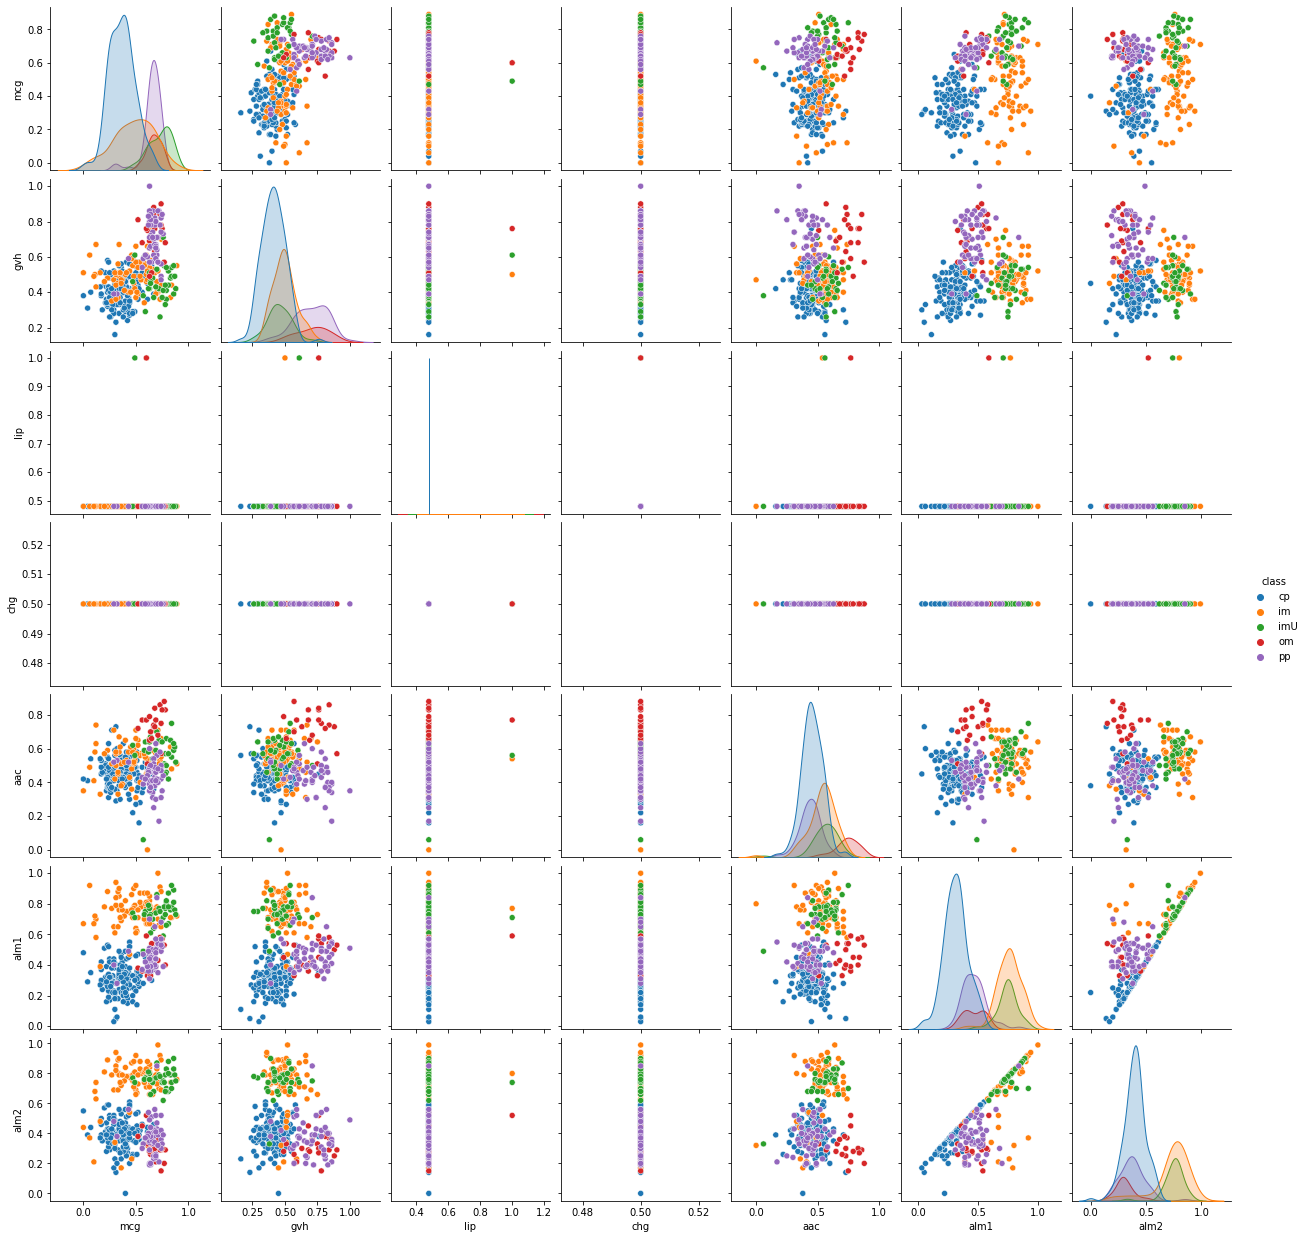

In [11]:
sns.pairplot(df,hue = 'class')

In [12]:
encoder = LabelEncoder(["class"])
df_enc = encoder.fit_transform(df)

In [13]:
df_enc["class"]

0      1
1      1
2      1
3      1
4      1
      ..
322    5
323    5
324    5
325    5
326    5
Name: class, Length: 327, dtype: int64

In [14]:
df_enc["class"]-1 #왜 1을 빼지?

0      0
1      0
2      0
3      0
4      0
      ..
322    4
323    4
324    4
325    4
326    4
Name: class, Length: 327, dtype: int64

In [15]:
encoder = LabelEncoder(["class"])
df_enc = encoder.fit_transform(df)
df_enc["class"] = df_enc["class"] - 1

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 327 entries, 0 to 326
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   SequenceName  327 non-null    object 
 1   mcg           327 non-null    float64
 2   gvh           327 non-null    float64
 3   lip           327 non-null    float64
 4   chg           327 non-null    float64
 5   aac           327 non-null    float64
 6   alm1          327 non-null    float64
 7   alm2          327 non-null    float64
 8   class         327 non-null    object 
dtypes: float64(7), object(2)
memory usage: 23.1+ KB


In [17]:
# drop columns we won't need in this example
df_enc = df_enc.drop(columns=["SequenceName"])

In [18]:
# train/valid/test = 0.8 : 0.1 : 0.1

df_train, df_valid = train_test_split(
    df_enc, test_size=0.2, stratify=df_enc["class"], random_state=1
)

df_valid, df_test = train_test_split(
    df_valid, test_size=0.5, stratify=df_valid["class"], random_state=1
)

In [19]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 261 entries, 250 to 276
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   mcg     261 non-null    float64
 1   gvh     261 non-null    float64
 2   lip     261 non-null    float64
 3   chg     261 non-null    float64
 4   aac     261 non-null    float64
 5   alm1    261 non-null    float64
 6   alm2    261 non-null    float64
 7   class   261 non-null    int64  
dtypes: float64(7), int64(1)
memory usage: 18.4 KB


## Preparing the data

In [20]:
continuous_cols = df_enc.drop(columns=["class"]).columns.values.tolist() 

In [21]:
continuous_cols

['mcg', 'gvh', 'lip', 'chg', 'aac', 'alm1', 'alm2']

In [22]:
# deeptabular
tab_preprocessor = TabPreprocessor(continuous_cols=continuous_cols, scale=True) #타겟 리스트를 TabPreprocessor 형식으로 만든다. 만약, categorize인 cols가 있으면 넣어준다.
X_tab_train = tab_preprocessor.fit_transform(df_train)
X_tab_valid = tab_preprocessor.transform(df_valid)
X_tab_test = tab_preprocessor.transform(df_test)

# target
y_train = df_train["class"].values #데이터 프레임을 넘파이 형식으로 반환
y_valid = df_valid["class"].values
y_test = df_test["class"].values

X_train = {"X_tab": X_tab_train, "target": y_train} # 왜 딕셔너리 형태로 집어넣을까?
X_val = {"X_tab": X_tab_valid, "target": y_valid}

## Define the model

In [23]:
df_enc["class"].nunique()

5

In [24]:
deeptabular = TabMlp( #deeptabular 에서 연속형 변수와 카테고리형 변수를 묶어준다. 이진분류에서는 wide 사용 했는데 여기서는 안 보인다.
    column_idx=tab_preprocessor.column_idx,
    continuous_cols=tab_preprocessor.continuous_cols,
)
model = WideDeep(deeptabular=deeptabular, pred_dim=df_enc["class"].nunique()) #nunique는 데이터 고유값 수를 출력해준다. 5차원 출력
model

WideDeep(
  (deeptabular): Sequential(
    (0): TabMlp(
      (cat_and_cont_embed): DiffSizeCatAndContEmbeddings(
        (cont_norm): BatchNorm1d(7, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (tab_mlp): MLP(
        (mlp): Sequential(
          (dense_layer_0): Sequential(
            (0): Dropout(p=0.1, inplace=False)
            (1): Linear(in_features=7, out_features=200, bias=True)
            (2): ReLU(inplace=True)
          )
          (dense_layer_1): Sequential(
            (0): Dropout(p=0.1, inplace=False)
            (1): Linear(in_features=200, out_features=100, bias=True)
            (2): ReLU(inplace=True)
          )
        )
      )
    )
    (1): Linear(in_features=100, out_features=5, bias=True)
  )
)

In [25]:
auroc = AUROC(num_classes=df_enc["class"].nunique())

/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


In [26]:
# Optimizers
deep_opt = SGD(model.deeptabular.parameters(), lr=0.1)
# LR Scheduler
deep_sch = lr_scheduler.StepLR(deep_opt, step_size=3)
# Hyperparameters
trainer = Trainer(
    model,
    objective="multiclass_focal_loss",
    lr_schedulers={"deeptabular": deep_sch},
    initializers={"deeptabular": XavierNormal},
    optimizers={"deeptabular": deep_opt},
    metrics=[auroc,Precision, Recall,F1Score],
)

trainer.fit(X_train=X_train, X_val=X_val, n_epochs=5, batch_size=50)

valid: 100%|██████████| 1/1 [00:00<00:00,  8.76it/s, loss=0.101, metrics={'AUROC': 0.7344, 'Precision': 0.5152, 'Recall': 0.5152, 'F1Score': 0.5152}]
